In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
import xgboost
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import linspace
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import kneighbors_graph

# Read the cleaned data
trainDataOriginal = pd.read_csv('train_data.csv')
# testDataOriginal = pd.read_csv('test_data.csv')

In [91]:
# allData = trainDataOriginal[((trainDataOriginal['year'] <= 2011) & (trainDataOriginal['year'] > 2008)) | 
# # allData = trainDataOriginal[(trainDataOriginal['year'] <= 2011) | 
#                               ((trainDataOriginal['year'] == 2012) & (trainDataOriginal['month'] <= 7)) ]

allData = trainDataOriginal[(trainDataOriginal['year'] <= 2017) & (trainDataOriginal['year'] > 2014)]

allData = allData[allData['inning'] == 1]
innings = allData['innings_no'].unique()
len(innings)

inningsViceData = {}
for inning in innings:
    inningData = allData[allData['innings_no'] == inning]
#     if inningData['over'].iloc[-1] != 50:
#         continue

    inningsViceData[inning] = inningData

#  SPlit train and test data
trainList = []
testList = []
trainDataCount = len(inningsViceData) - 25
count = 0;
for key, value in inningsViceData.items():
    if(count < trainDataCount):
        trainList.append(value)
    else:
        testList.append(value)
    count += 1

print("Done!")

trainData = pd.concat(trainList, ignore_index=True)
testData = pd.concat(testList, ignore_index=True)

a = trainData.groupby(['innings_no']).last()
b = testData.groupby(['innings_no']).last()
print (a.shape, b.shape)

Done!
(205, 38) (25, 38)


In [92]:
x = trainData.copy()
x['cluster'] = pd.cut(x['balls_remaining'], 
                      [-1,30,60,90,120,150,180,210,240,270,320], 
                      labels=[9,8,7,6,5,4,3,2,1,0])

# x[x['cluster'] == 1].head(20)

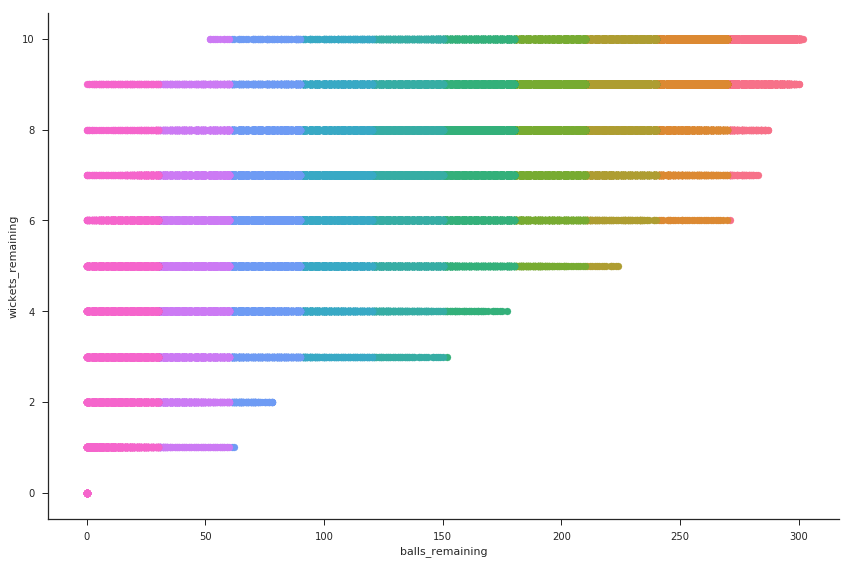

In [93]:
import seaborn
seaborn.set(style='ticks')

# drawData = x[x['cluster'] == 1]
drawData = x

plt.figure(1, figsize = (20, 20))
fg = seaborn.FacetGrid(data=drawData, hue='cluster', hue_order=drawData['cluster'].unique(), aspect=1.5, size=8)
fg.map(plt.scatter, 'balls_remaining', 'wickets_remaining')

plt.show()

In [94]:
rfs = []

# 1
rfs.append(RandomForestRegressor(n_estimators=10,
                               min_samples_split=0.001,
                               min_samples_leaf = 150,
                               max_leaf_nodes=80,
                               min_weight_fraction_leaf=0.001,
                               min_impurity_decrease=0.001
                              )
         )

# 2
rfs.append(RandomForestRegressor(n_estimators=10, 
                           min_samples_split=0.0001,
                           min_samples_leaf = 250,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01
                                )
         )

# 3
rfs.append(RandomForestRegressor(n_estimators=20, 
                           min_samples_split=0.0001,
                           min_samples_leaf = 200,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01
                                )
         )

# 4
rfs.append(RandomForestRegressor(n_estimators=20, 
                           min_samples_split=0.0001,
                           min_samples_leaf = 200,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01
                                )
         )
# 5
rfs.append(RandomForestRegressor(n_estimators=20, 
                           min_samples_split=0.0001,
                           min_samples_leaf = 200,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01
                                )
         )
# 6
rfs.append(RandomForestRegressor(n_estimators=20, 
                           min_samples_split=0.0001,
                           min_samples_leaf = 200,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01
                                )
         )
# 7
rfs.append(RandomForestRegressor(n_estimators=20, 
                           min_samples_split=0.0001,
                           min_samples_leaf = 200,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01
                                )
         )
# 8
rfs.append(RandomForestRegressor(n_estimators=20, 
                           min_samples_split=0.0001,
                           min_samples_leaf = 200,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01
                                )
         )
# 9
rfs.append(RandomForestRegressor(n_estimators=50,
                               min_samples_split=0.001,
                               min_samples_leaf = 150,
#                                max_leaf_nodes=50,
                               min_weight_fraction_leaf=0.001,
                               min_impurity_decrease=0.001
                              )
         )
# 10
rfs.append(RandomForestRegressor(n_estimators=10,
                               min_samples_split=0.001,
                               min_samples_leaf = 150,
                               max_leaf_nodes=50,
                               min_weight_fraction_leaf=0.001,
                               min_impurity_decrease=0.001
                              )
         )

In [101]:
clusters = x['cluster'].unique()

models = {}

cat_features = ['country_Australia','country_Bangladesh','country_England','country_India','country_New Zealand',
                'country_Pakistan','country_South Africa','country_Sri Lanka','country_West Indies',
                'country_Zimbabwe','opponent_Australia','opponent_Bangladesh','opponent_England','opponent_India',
                'opponent_New Zealand','opponent_Pakistan','opponent_South Africa','opponent_Sri Lanka',
                'opponent_West Indies','opponent_Zimbabwe']

# cat_features = ['country_Australia','country_Bangladesh','country_England','country_India','country_New Zealand',
#                 'country_Pakistan','country_South Africa','country_Sri Lanka','country_West Indies',
#                 'country_Zimbabwe']

# cat_features = []

required_features = ['last_five_runrate','current_score', 'balls_remaining', 'wickets_remaining','avg_score']

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols


counter = 0
for cluster_id in clusters:
    train_data_segemnt = x[x['cluster'] == cluster_id]
    y_train = train_data_segemnt['run_scored'].astype(int)
    x_train = train_data_segemnt.drop(['run_scored', 'final_score'], axis=1)

    feature_selection = FeatureUnion([
                        ('num', Pipeline([('extract', ColumnExtractor(columns=required_features))])),
                        ('cat_var', ColumnExtractor(columns=cat_features))]);
    
    rf = RandomForestRegressor(n_estimators=50, 
                           min_samples_split=0.01,
                           min_samples_leaf = 150,
                           max_leaf_nodes=50,
                           min_weight_fraction_leaf=0.01, 
                           min_impurity_decrease=0.01)

    xgb = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.001, max_depth=5, subsample=0.005,
                           colsample_bytree=1, min_child_weight=0.005, silent=False, n_jobs=4)
    
    pipeline = Pipeline([
                    ('features', feature_selection),
                    ('standardizer', MinMaxScaler()),
#                     ('estimator', rfs[cluster_id])
                    ('estimator', rf)
                ])
    print('Training model ' + str(cluster_id + 1) + ' out of ' + str(len(clusters)) + ' complete')
    pipeline.fit(x_train, y_train)
    models[str(cluster_id)] = pipeline
    counter += 1
    
print("Training complete!")

Training model 1 out of 10 complete
Training model 2 out of 10 complete
Training model 3 out of 10 complete
Training model 4 out of 10 complete
Training model 5 out of 10 complete
Training model 6 out of 10 complete
Training model 7 out of 10 complete
Training model 8 out of 10 complete
Training model 9 out of 10 complete
Training model 10 out of 10 complete
Training complete!


In [102]:
# Validate
actuals = []
predicted = []
segments= []

clustered_test_data = testData.copy()
clustered_test_data['cluster'] = pd.cut(clustered_test_data['balls_remaining'], 
                                        [-1,30,60,90,120,150,180,210,240,270,320], 
                                        labels=[9,8,7,6,5,4,3,2,1,0])

for cluster_id in np.unique(clustered_test_data['cluster']):
    
    test_data_segment = clustered_test_data[clustered_test_data['cluster']  == cluster_id]
    segments.append(test_data_segment)

    y_test = test_data_segment['run_scored'].astype(int)
    x_test = test_data_segment.drop(['run_scored', 'final_score'], axis=1)
    
    y_hat = models[str(cluster_id)].predict(x_test).astype(int)
    
    actuals = np.concatenate((actuals, y_test), axis=0)
    predicted = np.concatenate((predicted, y_hat), axis=0)

validate_data =  pd.concat(segments, ignore_index=True)

# y_hat = np.exp(y_hat) - 1

# Compare results
results = pd.DataFrame()
results['actual'] = actuals
results['prediction'] = predicted
results.reset_index(drop=True, inplace=True)

print('Prediction complete!')

Prediction complete!


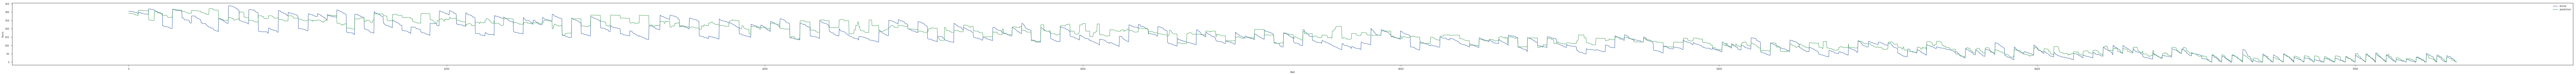

In [103]:
import matplotlib.pyplot as plt
results.plot(figsize=(200,5))
plt.xlabel('Ball')
plt.ylabel('Runs')
plt.show()

In [104]:
mse = mean_squared_error(results['actual'], results['prediction']);
print('MSE', mse)
print('RMSE', np.sqrt(mse))

MSE 1535.9886612021858
RMSE 39.191691226613145


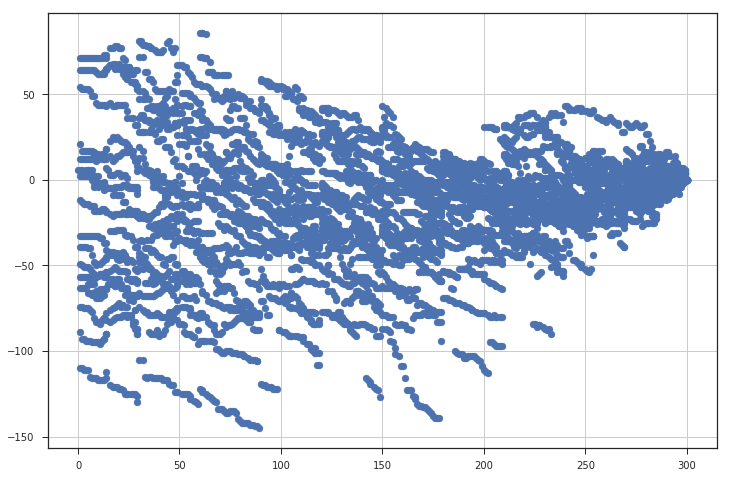

In [105]:
compare = pd.DataFrame()
compare['actualTotal'] = validate_data['current_score'] + results['actual']
compare['predictedTotal'] = validate_data['current_score'] + results['prediction']

plt.figure(1, figsize = (12, 8))
plt.scatter(300 - validate_data['balls_remaining'], results['actual'] - results['prediction'])
plt.grid()

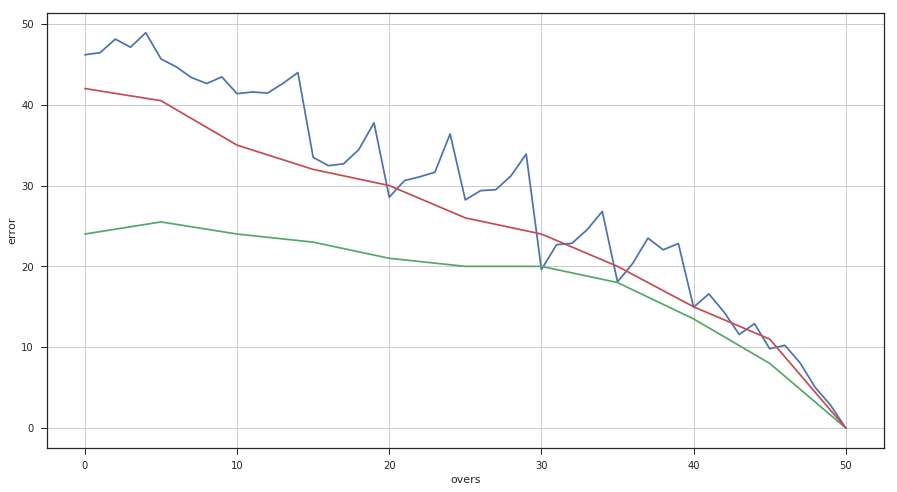

In [106]:
compare['balls'] = 300 - validate_data['balls_remaining']
compare['error'] = (results['actual'] - results['prediction']).abs()
compare['overs'] = (compare['balls'] / 6).astype(int)

comparePerBall = compare.groupby(['balls'], as_index=False).mean()
comparePerOver = compare.groupby(['overs'], as_index=False).mean()

comparePerFiveOvers = [comparePerOver.iloc[0].error, comparePerOver.iloc[5].error, comparePerOver.iloc[10].error,
                        comparePerOver.iloc[15].error, comparePerOver.iloc[20].error, comparePerOver.iloc[25].error,
                        comparePerOver.iloc[30].error, comparePerOver.iloc[35].error, comparePerOver.iloc[40].error,
                        comparePerOver.iloc[45].error, comparePerOver.iloc[50].error]

plt.figure(1, figsize = (15, 8))
plt.clf()
# plt.scatter(comparePerOver['balls'], comparePerOver['error'])

comparePerOver['error'].plot(figsize=(15, 8))

plt.xlabel('overs')
plt.ylabel('error')

# PLot the datamining aproach results to comprae as our base model
t = linspace(0, 50, 11)
# t = [0, 5]
dmModel = [24, 25.5, 24, 23, 21, 20, 20, 18, 13.5, 8, 0]

baileyModel = [42, 40.5, 35, 32, 30, 26, 24, 20, 15, 11, 0]


# dmModel = [8, 0]
# baileyModel = [11, 0]
overs = pd.DataFrame(t)
plt.plot(t, dmModel)
plt.plot(t, baileyModel)
# plt.plot(t, comparePerFiveOvers)

plt.grid()
plt.show()

In [14]:
# # Cross validation

# from sklearn.model_selection import validation_curve

# #  Data fro cross validation
# cluster_id = 0
# train_data_segemnt = x[x['cluster'] == 0]
# y_train = train_data_segemnt['run_scored'].astype(int)
# x_train = train_data_segemnt.drop(['run_scored', 'final_score'], axis=1)
    

# #  pipe line
# # rf = RandomForestRegressor(n_estimators=100, criterion='mse', max_features=1.0,
# #                                max_depth=None, min_samples_split=10, min_samples_leaf=10, 
# #                                min_weight_fraction_leaf=0.1, max_leaf_nodes=10, 
# #                                min_impurity_decrease=0.00001, verbose=False)

# # for 50 clusters
# testRF = RandomForestRegressor(n_estimators=300, 
#                                min_samples_split=0.0001,
#                                min_samples_leaf = 80,
#                                min_weight_fraction_leaf=0.01, 
#                                min_impurity_decrease=0.01
#                               )

# #  Ideal
# # rf = RandomForestRegressor(n_estimators=50, 
# #                            min_samples_split=0.001,
# #                            min_samples_leaf = 150,
# #                            max_leaf_nodes=50,
# #                            min_weight_fraction_leaf=0.001, 
# #                            min_impurity_decrease=0.001)

# pipeline = Pipeline([
#                 ('features', feature_selection),
#                 ('standardizer', MinMaxScaler()),
#                 ('estimator', testRF)
#             ])
    
# # params
# n_estimators = [5, 10, 50, 100, 500, ]
# max_depth = [500, 1000, 5000, 100, 500]
# max_leaf_nodes = [5, 10, 50, 100, 500]
# min_samples_leaf = [50, 60, 70, 80, 90, 100, 150, 200, 250, 300]
# min_samples_split = max_features = min_weight_fraction_leaf = [0.5, 0.1, 0.01, 0.001, 0.001, 0.0001]
# min_impurity_decrease = [0.1, 0.01, 0.001, 0.001, 0.0001]
# bootstrap = [True, False]
# criterion = ['mse', 'mae']
# max_features = [0.5, 0.1, 0.01, 0.001, 0.001, 0.0001]

# param_range = min_samples_split
# train_scores, valid_scores = validation_curve(pipeline, x_train, y_train, 
#                                               param_name='estimator__min_samples_split',
#                                               param_range=param_range, verbose=2)

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(valid_scores, axis=1)
# test_scores_std = np.std(valid_scores, axis=1)

# plt.figure(1, figsize = (10, 10))
# plt.title("Validation Curve")
# plt.xlabel("$\gamma$")
# plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
# lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
# plt.legend(loc="best")
# plt.xticks(param_range, param_range)

# plt.grid()
# plt.show()